# MP5: Training Your Diffusion Model!

## Setup environment

In [1]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch # added
from torch import optim # added
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import GaussianNoise
import torchvision.utils as vutils
import numpy as np

In [2]:
def visualize_images_with_titles(images: torch.Tensor, column_names: list[str]):
    """
    Visualize images as a grid and title the columns with the provided names.

    Args:
        images: (N, C, H, W) tensor of images, where N is (number of rows * number of columns)
        column_names: List of column names for the titles.

    Example usage:
    visualize_images_with_titles(torch.randn(16, 1, 32, 32), ['1', '2', '3', '4'])
    """
    numimgs, num_columns = images.shape[0], len(column_names)
    assert numimgs % num_columns == 0, 'Number of images must be a multiple of the number of columns.'

    num_rows = numimgs // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(num_columns * 1, num_rows * 1))

    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i < num_columns:
            ax.set_title(column_names[i % num_columns])

    plt.tight_layout()
    plt.show()


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [20]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        #TODO: Add Num Features
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=1,padding=1)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        #TODO: Add Num Features
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size=3,stride=2,padding=1)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        #TODO: Add Num Features
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,kernel_size=4,stride=2,padding=1)
        self.bnorm = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(7)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        x = self.pool(x)
        flatout = self.gelu(x)
        return flatout

class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, in_channels,kernel_size=7,stride=7,padding=0)
        self.bnorm = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        xb = self.conv(x)
        y = self.bnorm(xb)
        convout = self.gelu(y)
        return convout


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels,out_channels)
        self.conv2 = Conv(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # raise NotImplementedError()
        print(x.shape)
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        return out2

class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = DownConv(in_channels,out_channels)
        self.conv2 = ConvBlock(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        return out2


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = UpConv(in_channels,out_channels)
        self.conv2 = ConvBlock(out_channels,out_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        return out2

## Implementing Unconditional UNet

In [21]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.convb1 = ConvBlock(in_channels,num_hiddens)
        self.downb1 = DownBlock(num_hiddens,num_hiddens)
        self.downb2 = DownBlock(num_hiddens,num_hiddens*2)
        self.flat1 = Flatten()
        self.unflat1 = Unflatten(num_hiddens*2)
        #Concat w/ downb2
        self.upb1 = UpBlock(num_hiddens*4,num_hiddens)
        #Concat w/ downb1
        self.upb2 = UpBlock(num_hiddens*2,num_hiddens)
        #Concat w/ convb1
        self.convb2 = ConvBlock(num_hiddens*2,num_hiddens)
        self.convf = Conv(num_hiddens,in_channels)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        # print(x.shape)
        convb1   = self.convb1(x)
        downb1   = self.downb1(convb1)
        downb2   = self.downb2(downb1)
        flat1    = self.flat1(downb2)
        unflat1  = self.unflat1(flat1)
        concat1 = torch.cat((downb2,unflat1),dim=1)
        upb1 = self.upb1(concat1)
        concat2 = torch.cat((downb1,upb1),dim=1)
        upb2 = self.upb2(concat2)
        concat3 = torch.cat((convb1,upb2),dim=1)
        convb2 = self.convb2(concat3)
        convf = self.convf(convb2)
        return convf

## Visualizing the noising process

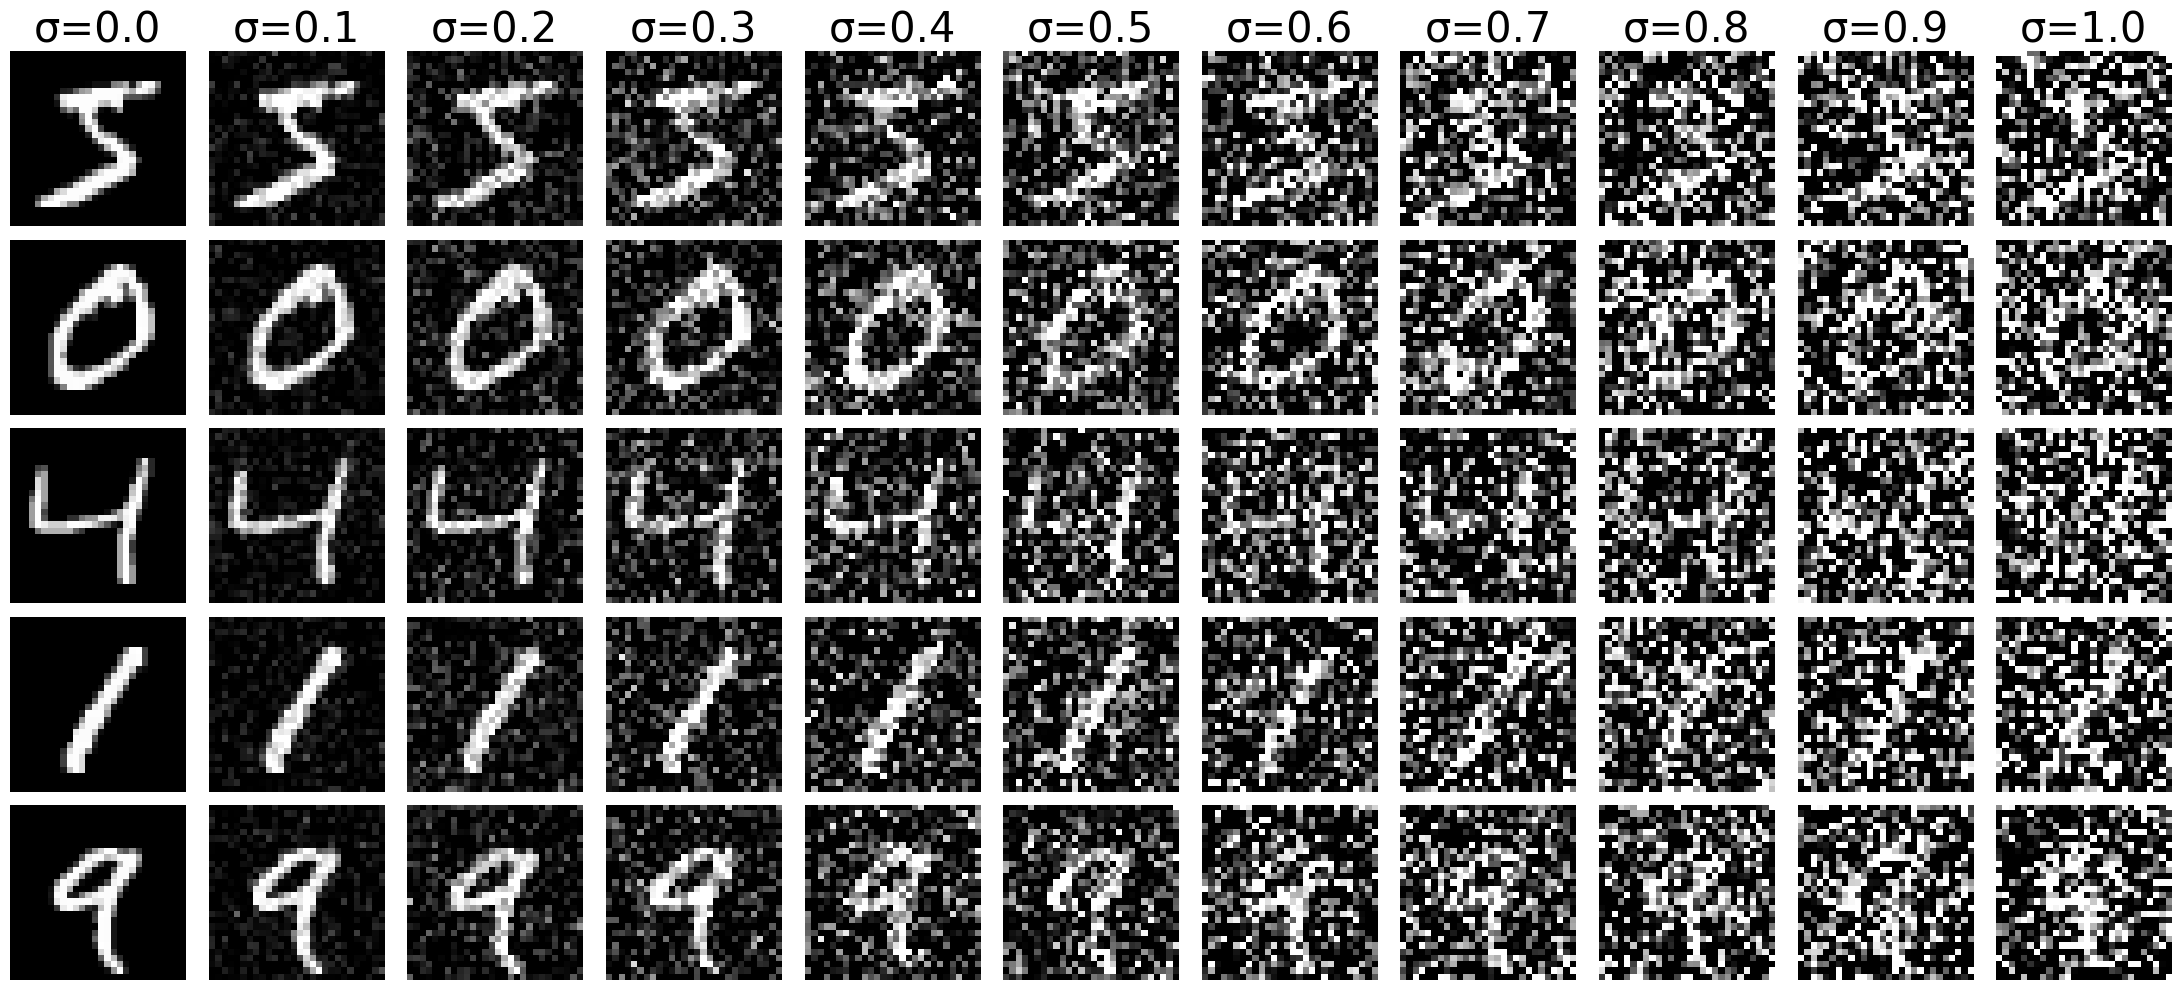

In [22]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
sigma = np.arange(0,11)/10
# img, _ = dataset[0]  # img shape: [1, 28, 28]

# Define noise levels
sigma_values = np.arange(0, 11) / 10 
numimgs = 5
images = torch.stack([dataset[i][0] for i in range(numimgs)])  # shape: [N, 1, 28, 28]
fig, axs = plt.subplots(numimgs, 11, figsize=(11 * 2, numimgs * 2))
for col, sigma in enumerate(sigma_values):
    noise_transform = GaussianNoise(sigma=sigma)
    noisy_images = torch.stack([noise_transform(img) for img in images])

    for row in range(numimgs):
        axs[row, col].imshow(noisy_images[row].squeeze(0), cmap='gray')
        axs[row, col].axis('off')
        if row == 0:
            axs[row, col].set_title(f"σ={sigma:.1f}", fontsize=30)

plt.tight_layout()
plt.show()
# TODO

## Training a Single-Step Unconditional UNet

- Plot the loss curve
- Sample results on the test set

In [23]:
# traindata = MNIST(root="data", download=True, transform=ToTensor(), train=True)


In [ ]:
from tqdm import tqdm 
# traindata = MNIST(root="data", download=True, transform=ToTensor(), train=True)
trainloader = DataLoader(dataset,batch_size=256,shuffle=True,num_workers=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UnconditionalUNet(in_channels=1,num_hiddens=128).to(device)

criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-4)


model.train()
running_loss = 0.0
noise_transform = GaussianNoise(sigma=0.5)
total_loss = []
model.train()

for epoch in range(5):
    epoch_loss = 0.0
    for images, _ in tqdm(trainloader):
        images = images.to(device)

        # Apply v2 transform manually inside loop
        noisy_images = noise_transform(images)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # running_loss += loss.item()
        avg_loss = epoch_loss / len(trainloader)
        total_loss.append(avg_loss)
        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(trainloader):.4f}")
# TODO

  0%|          | 0/235 [00:00<?, ?it/s]

torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  0%|          | 1/235 [00:25<1:38:44, 25.32s/it]

Epoch 1 Loss: 0.0019
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  1%|          | 2/235 [00:34<1:02:21, 16.06s/it]

Epoch 1 Loss: 0.0032
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  1%|▏         | 3/235 [00:44<50:02, 12.94s/it]  

Epoch 1 Loss: 0.0041
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  2%|▏         | 4/235 [00:52<43:35, 11.32s/it]

Epoch 1 Loss: 0.0047
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  2%|▏         | 5/235 [01:01<39:36, 10.33s/it]

Epoch 1 Loss: 0.0051
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  3%|▎         | 6/235 [01:10<37:58,  9.95s/it]

Epoch 1 Loss: 0.0054
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  3%|▎         | 7/235 [01:19<36:26,  9.59s/it]

Epoch 1 Loss: 0.0056
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  3%|▎         | 8/235 [01:28<35:15,  9.32s/it]

Epoch 1 Loss: 0.0059
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  4%|▍         | 9/235 [01:36<33:59,  9.02s/it]

Epoch 1 Loss: 0.0061
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  4%|▍         | 10/235 [01:46<34:17,  9.15s/it]

Epoch 1 Loss: 0.0063
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  5%|▍         | 11/235 [01:57<36:28,  9.77s/it]

Epoch 1 Loss: 0.0065
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  5%|▌         | 12/235 [02:10<40:22, 10.86s/it]

Epoch 1 Loss: 0.0067
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  6%|▌         | 13/235 [02:24<42:57, 11.61s/it]

Epoch 1 Loss: 0.0068
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  6%|▌         | 14/235 [02:39<47:16, 12.84s/it]

Epoch 1 Loss: 0.0070
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  6%|▋         | 15/235 [02:58<53:53, 14.70s/it]

Epoch 1 Loss: 0.0071
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  7%|▋         | 16/235 [03:16<57:03, 15.63s/it]

Epoch 1 Loss: 0.0073
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  7%|▋         | 17/235 [03:39<1:04:57, 17.88s/it]

Epoch 1 Loss: 0.0074
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  8%|▊         | 18/235 [03:59<1:06:26, 18.37s/it]

Epoch 1 Loss: 0.0076
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  8%|▊         | 19/235 [04:19<1:07:59, 18.89s/it]

Epoch 1 Loss: 0.0077
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  9%|▊         | 20/235 [04:38<1:08:38, 19.16s/it]

Epoch 1 Loss: 0.0078
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  9%|▉         | 21/235 [04:58<1:08:52, 19.31s/it]

Epoch 1 Loss: 0.0080
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


  9%|▉         | 22/235 [05:19<1:10:24, 19.83s/it]

Epoch 1 Loss: 0.0081
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 10%|▉         | 23/235 [05:39<1:09:34, 19.69s/it]

Epoch 1 Loss: 0.0082
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 10%|█         | 24/235 [05:57<1:08:23, 19.45s/it]

Epoch 1 Loss: 0.0083
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 11%|█         | 25/235 [06:18<1:09:09, 19.76s/it]

Epoch 1 Loss: 0.0084
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 11%|█         | 26/235 [06:38<1:09:01, 19.82s/it]

Epoch 1 Loss: 0.0086
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 11%|█▏        | 27/235 [06:53<1:04:00, 18.46s/it]

Epoch 1 Loss: 0.0087
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 12%|█▏        | 28/235 [07:07<58:44, 17.02s/it]  

Epoch 1 Loss: 0.0088
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 12%|█▏        | 29/235 [07:22<56:59, 16.60s/it]

Epoch 1 Loss: 0.0089
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 13%|█▎        | 30/235 [07:41<58:50, 17.22s/it]

Epoch 1 Loss: 0.0090
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 13%|█▎        | 31/235 [08:01<1:01:22, 18.05s/it]

Epoch 1 Loss: 0.0091
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 14%|█▎        | 32/235 [08:21<1:02:50, 18.58s/it]

Epoch 1 Loss: 0.0092
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 14%|█▍        | 33/235 [08:35<58:25, 17.35s/it]  

Epoch 1 Loss: 0.0094
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 14%|█▍        | 34/235 [08:50<55:01, 16.43s/it]

Epoch 1 Loss: 0.0095
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 15%|█▍        | 35/235 [09:04<52:17, 15.69s/it]

Epoch 1 Loss: 0.0096
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 15%|█▌        | 36/235 [09:20<52:48, 15.92s/it]

Epoch 1 Loss: 0.0097
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 16%|█▌        | 37/235 [09:39<55:52, 16.93s/it]

Epoch 1 Loss: 0.0098
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 16%|█▌        | 38/235 [09:56<55:25, 16.88s/it]

Epoch 1 Loss: 0.0099
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 17%|█▋        | 39/235 [10:10<51:59, 15.92s/it]

Epoch 1 Loss: 0.0100
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 17%|█▋        | 40/235 [10:21<47:10, 14.51s/it]

Epoch 1 Loss: 0.0101
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 17%|█▋        | 41/235 [10:33<44:04, 13.63s/it]

Epoch 1 Loss: 0.0102
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 18%|█▊        | 42/235 [10:45<42:07, 13.10s/it]

Epoch 1 Loss: 0.0103
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 18%|█▊        | 43/235 [10:58<42:15, 13.21s/it]

Epoch 1 Loss: 0.0104
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 19%|█▊        | 44/235 [11:14<44:17, 13.91s/it]

Epoch 1 Loss: 0.0105
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 19%|█▉        | 45/235 [11:32<48:31, 15.33s/it]

Epoch 1 Loss: 0.0106
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 20%|█▉        | 46/235 [11:51<51:27, 16.34s/it]

Epoch 1 Loss: 0.0107
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 20%|██        | 47/235 [12:08<51:49, 16.54s/it]

Epoch 1 Loss: 0.0108
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 20%|██        | 48/235 [12:23<49:52, 16.00s/it]

Epoch 1 Loss: 0.0109
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 21%|██        | 49/235 [12:35<45:51, 14.79s/it]

Epoch 1 Loss: 0.0110
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 21%|██▏       | 50/235 [12:48<44:23, 14.39s/it]

Epoch 1 Loss: 0.0111
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 22%|██▏       | 51/235 [13:04<45:21, 14.79s/it]

Epoch 1 Loss: 0.0112
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 22%|██▏       | 52/235 [13:22<47:54, 15.71s/it]

Epoch 1 Loss: 0.0113
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 23%|██▎       | 53/235 [13:40<50:32, 16.66s/it]

Epoch 1 Loss: 0.0113
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 23%|██▎       | 54/235 [13:55<48:37, 16.12s/it]

Epoch 1 Loss: 0.0114
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 23%|██▎       | 55/235 [14:07<44:22, 14.79s/it]

Epoch 1 Loss: 0.0115
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 24%|██▍       | 56/235 [14:19<41:12, 13.81s/it]

Epoch 1 Loss: 0.0116
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 24%|██▍       | 57/235 [14:31<40:02, 13.50s/it]

Epoch 1 Loss: 0.0117
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 25%|██▍       | 58/235 [14:44<39:19, 13.33s/it]

Epoch 1 Loss: 0.0118
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 25%|██▌       | 59/235 [15:01<41:49, 14.26s/it]

Epoch 1 Loss: 0.0119
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 26%|██▌       | 60/235 [15:19<44:56, 15.41s/it]

Epoch 1 Loss: 0.0120
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 26%|██▌       | 61/235 [15:38<47:42, 16.45s/it]

Epoch 1 Loss: 0.0121
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 26%|██▋       | 62/235 [15:53<46:35, 16.16s/it]

Epoch 1 Loss: 0.0122
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 27%|██▋       | 63/235 [16:06<43:14, 15.08s/it]

Epoch 1 Loss: 0.0122
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 27%|██▋       | 64/235 [16:20<41:58, 14.73s/it]

Epoch 1 Loss: 0.0123
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 28%|██▊       | 65/235 [16:35<42:30, 15.01s/it]

Epoch 1 Loss: 0.0124
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 28%|██▊       | 66/235 [16:53<44:15, 15.71s/it]

Epoch 1 Loss: 0.0125
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 29%|██▊       | 67/235 [17:07<42:57, 15.34s/it]

Epoch 1 Loss: 0.0126
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 29%|██▉       | 68/235 [17:19<39:42, 14.26s/it]

Epoch 1 Loss: 0.0127
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 29%|██▉       | 69/235 [17:34<40:07, 14.51s/it]

Epoch 1 Loss: 0.0128
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 30%|██▉       | 70/235 [17:52<42:38, 15.51s/it]

Epoch 1 Loss: 0.0128
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 30%|███       | 71/235 [18:11<45:19, 16.58s/it]

Epoch 1 Loss: 0.0129
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 31%|███       | 72/235 [18:26<43:34, 16.04s/it]

Epoch 1 Loss: 0.0130
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 31%|███       | 73/235 [18:37<39:47, 14.74s/it]

Epoch 1 Loss: 0.0131
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 31%|███▏      | 74/235 [18:48<35:57, 13.40s/it]

Epoch 1 Loss: 0.0132
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 32%|███▏      | 75/235 [18:59<34:21, 12.89s/it]

Epoch 1 Loss: 0.0132
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 32%|███▏      | 76/235 [19:12<34:05, 12.87s/it]

Epoch 1 Loss: 0.0133
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 33%|███▎      | 77/235 [19:26<34:50, 13.23s/it]

Epoch 1 Loss: 0.0134
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 33%|███▎      | 78/235 [19:41<35:36, 13.61s/it]

Epoch 1 Loss: 0.0135
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 34%|███▎      | 79/235 [19:57<37:50, 14.56s/it]

Epoch 1 Loss: 0.0136
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 34%|███▍      | 80/235 [20:15<39:50, 15.42s/it]

Epoch 1 Loss: 0.0137
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 34%|███▍      | 81/235 [20:31<40:21, 15.73s/it]

Epoch 1 Loss: 0.0137
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 35%|███▍      | 82/235 [20:46<39:23, 15.45s/it]

Epoch 1 Loss: 0.0138
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 35%|███▌      | 83/235 [21:00<37:44, 14.90s/it]

Epoch 1 Loss: 0.0139
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 36%|███▌      | 84/235 [21:15<37:32, 14.92s/it]

Epoch 1 Loss: 0.0140
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 36%|███▌      | 85/235 [21:30<37:55, 15.17s/it]

Epoch 1 Loss: 0.0140
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 37%|███▋      | 86/235 [21:49<40:10, 16.18s/it]

Epoch 1 Loss: 0.0141
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 37%|███▋      | 87/235 [22:04<38:55, 15.78s/it]

Epoch 1 Loss: 0.0142
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 37%|███▋      | 88/235 [22:15<34:59, 14.28s/it]

Epoch 1 Loss: 0.0143
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 38%|███▊      | 89/235 [22:25<32:10, 13.22s/it]

Epoch 1 Loss: 0.0144
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 38%|███▊      | 90/235 [22:37<30:35, 12.66s/it]

Epoch 1 Loss: 0.0144
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


 39%|███▊      | 91/235 [22:49<29:54, 12.46s/it]

Epoch 1 Loss: 0.0145
torch.Size([256, 1, 28, 28])
torch.Size([256, 128, 14, 14])
torch.Size([256, 256, 7, 7])
torch.Size([256, 128, 14, 14])
torch.Size([256, 128, 28, 28])
torch.Size([256, 256, 28, 28])


## Out-of-Distribution Testing

In [ ]:
# TODO
model.eval()
sigma_values = np.arange(0, 11) / 10 
testdata= MNIST(root="data", download=True, transform=ToTensor(), train=False)
testloader =  DataLoader(testdata,batch_size=256,shuffle=True,num_workers=12)
sigmaloss =[]
with torch.no_grad():
    for sigma in sigma_values:
        noise_transform = GaussianNoise(mean=0.0, std=sigma)
        total_loss = 0.0
        shown = False
        for images, _ in tqdm(testloader, desc=f"σ={sigma:.1f}"):
            images = images.to(device)
            noisy_images = noise_transform(images)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
            if not shown:
                i = torch.randint(0, images.size(0), (1,)).item()
                sample = torch.stack([images[i], outputs[i]]) 
                vutils.save_image(sample, f"output_sigma_{sigma:.1f}.png", nrow=2, normalize=True)
                shown = True
        avg_loss = total_loss / len(testloader)
        sigmaloss.append(avg_loss)
        print(f"Sigma={sigma:.2f} | Avg Test Loss: {avg_loss:.4f}")

# Part 2: Training a Diffusion Model

## Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        raise NotImplementedError()

## Implementing DDPM Forward and Inverse Process for Time-conditioned Denoising

In [ ]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."
    raise NotImplementedError()

In [ ]:
def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

## Training the Time-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO

### Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        raise NotImplementedError()

In [ ]:
def ddpm_forward(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) diffusion loss.
    """
    unet.train()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
@torch.inference_mode()
def ddpm_sample(
    unet: ClassConditionalUNet,
    ddpm_schedule: dict,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: ClassConditionalUNet
        ddpm_schedule: dict
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    # YOUR CODE HERE.
    raise NotImplementedError()

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = nn.ParameterDict(ddpm_schedule(betas[0], betas[1], num_ts))

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

## Training the Class-conditioned UNet

- Plot the loss curve
- Sample results on the test set

In [ ]:
dataset = MNIST(root='data', download=True, transform=ToTensor(), train=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# TODO